# Heterogeneous graph attention networks

By Pavlin Poličar 15.10.2020

In [1]:
from enum import IntEnum
from math import comb

import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch_geometric as pyg

## Download and load data

In this notebook, we'll use two small data sets. One will be the same as in the previous notebook -- interactions between FDA-approved drugs (ChCh-Miner), while the other will be the interactions between the drugs and their corresponding targets (ChG-Miner). Both of these data sets can be obtained from the _Stanford Biomedical Network Dataset Collection_.

In [2]:
!mkdir -p data

!wget http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz -O data/ChCh-Miner_durgbank-chem-chem.tsv.gz
!wget http://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz -O data/ChG-Miner_miner-chem-gene.tsv.gz

!yes | gunzip data/ChCh-Miner_durgbank-chem-chem.tsv.gz
!yes | gunzip data/ChG-Miner_miner-chem-gene.tsv.gz

--2020-12-05 14:22:08--  http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206802 (202K) [application/x-gzip]
Saving to: ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’

data/ChCh-Miner_dur 100%[===================>] 201.96K   199KB/s    in 1.0s    

2020-12-05 14:22:10 (199 KB/s) - ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’ saved [206802/206802]

--2020-12-05 14:22:10--  http://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76098 (74K) [application/x-gzip]
Saving to: ‘data/ChG-Miner_miner-chem-gene.tsv.gz’

data/ChG-Mi

In [3]:
!head data/ChCh-Miner_durgbank-chem-chem.tsv

DB00862	DB00966
DB00575	DB00806
DB01242	DB08893
DB01151	DB08883
DB01235	DB01275
DB00018	DB00333
DB00201	DB01609
DB00712	DB01418
DB01576	DB04842
DB01609	DB06212


This time, we have two different node types: drugs and targets. The targets here are actual genes, so we assign each node and edge type its own id, so we can more easily identify them later on.

In [4]:
class NodeType(IntEnum):
    DRUG = 1
    GENE = 2
    
class EdgeType(IntEnum):
    DRUG_DRUG = 1
    DRUG_GENE = 2
    GENE_DRUG = 3
    GENE_GENE = 4
    
    @classmethod
    def from_nodes(cls, n1, n2):
        return {
            (NodeType.DRUG, NodeType.DRUG): cls.DRUG_DRUG,
            (NodeType.DRUG, NodeType.GENE): cls.DRUG_GENE,
            (NodeType.GENE, NodeType.DRUG): cls.GENE_DRUG,
            (NodeType.GENE, NodeType.GENE): cls.GENE_GENE,
        }[int(n1), int(n2)]

In [5]:
f1_drugs = set()
entity_dict, edge_index = {}, []
entity_count = 0  # we will use this to assign numbers to drugs
entity_type = []

with open("data/ChCh-Miner_durgbank-chem-chem.tsv") as f:
    for line in f:
        line = line.rstrip()
        d1, d2 = line.split("\t")
        
        if d1 not in entity_dict:
            entity_dict[d1] = entity_count
            entity_type.append(NodeType.DRUG)
            entity_count += 1
        if d2 not in entity_dict:
            entity_dict[d2] = entity_count
            entity_type.append(NodeType.DRUG)
            entity_count += 1
        
        edge_index.append([entity_dict[d1], entity_dict[d2]])
        f1_drugs.add(d1)
        f1_drugs.add(d2)

print(f"{len(edge_index):,} interactions")

48,514 interactions


In [6]:
!head data/ChG-Miner_miner-chem-gene.tsv

#Drug	Gene
DB00357	P05108
DB02721	P00325
DB00773	P23219
DB07138	Q16539
DB08136	P24941
DB01242	P23975
DB01238	P08173
DB00186	P48169
DB00338	P10635


In [7]:
f2_drugs = set()
with open("data/ChG-Miner_miner-chem-gene.tsv") as f:
    for line in f:
        line = line.rstrip()
        d1, d2 = line.split("\t")
        
        if d1 not in entity_dict:
            entity_dict[d1] = entity_count
            entity_type.append(NodeType.DRUG)
            entity_count += 1
        if d2 not in entity_dict:
            entity_dict[d2] = entity_count
            entity_type.append(NodeType.GENE)
            entity_count += 1
        
        edge_index.append([entity_dict[d1], entity_dict[d2]])
        f2_drugs.add(d1)

print(f"{len(edge_index):,} interactions")

63,654 interactions


Let's verify that at least some of the drugs overlap between the two datasets.

In [8]:
len(f1_drugs & f2_drugs)

1205

In [9]:
entity_type = torch.LongTensor(entity_type)
pd.Series.value_counts(entity_type.numpy())

1    5327
2    2325
dtype: int64

In [10]:
edge_index = torch.LongTensor(edge_index).T
edge_index

tensor([[   0,    2,    4,  ...,  923,  185, 7651],
        [   1,    3,    5,  ..., 2005, 1541, 1531]])

## Prepare graph
### Examine graph

In [11]:
print("Sparsity: %.2f" % (edge_index.size(1) / comb(len(edge_index[0].unique()), 2)))

Sparsity: 0.00


In [12]:
pyg.utils.is_undirected(edge_index)

False

Even though the graph is undirected, we're going to cast it to a directed graph, so this will be one less piece of complexity we will have to worry about.

In [13]:
edge_index = pyg.utils.to_undirected(edge_index)

In [14]:
num_nodes = entity_count
print(f"{num_nodes:,} nodes")

7,652 nodes


### Extract LCC

Many graph-based learning techniques cannot operate on disconnected graphs, so it is standard practice to operate on the largest connected component (LCC). The easiest way to exctract the LCC is to use _networkx_, a popular pure Python library for network analysis.

In [15]:
data = pyg.data.Data(edge_index=edge_index, node_type=entity_type)
nx_data = pyg.utils.to_networkx(data, to_undirected=True, node_attrs=["node_type"])
nx_data

In [16]:
connected_components = list(nx.connected_components(nx_data))
print(f"Graph contains {len(connected_components)} connected components")

Graph contains 178 connected components


In [17]:
lcc_nodes = max(connected_components, key=len)
lcc = nx_data.subgraph(lcc_nodes)
print(f"{lcc.number_of_nodes():,} nodes in LCC")

7,064 nodes in LCC


In [18]:
pyg.utils.from_networkx(lcc)

Data(edge_index=[2, 126466], node_type=[7064])

In [19]:
lcc_data = pyg.utils.from_networkx(lcc)
edge_index = lcc_data.edge_index
node_type = lcc_data.node_type

In [20]:
print(f"{len(edge_index.unique()):,} nodes")

7,064 nodes


### Determine edge types

The edge types here are important, as they each carry a different semantic meaning. Interactions between drugs are not semantically equivalent to interactions between drugs and their targets, so we make sure to differentiate between them.

In [21]:
edge_type = []
for n1, n2 in edge_index.T:
    edge_type.append(EdgeType.from_nodes(node_type[n1], node_type[n2]))

In [22]:
pd.Series.value_counts(edge_type)

1    97028
3    14719
2    14719
dtype: int64

Notice that there is the same number of edges of types 2 and 3. This is because one of these corresponds to drug-gene and the other to gene-drug edges. Because we cast our graph to an undirected graph, this makes perfect sense.

In [23]:
edge_type = torch.LongTensor(edge_type)

## Prepare data set

As in any machine learning task, we split our data set into a training and validation set. In _torch_geometric_, it is easiest to define boolean masks to indicate which edges belong into each set. Why not use integer indices? Because we can easily attach boolean masks to a _torch_geometric_ `pyg.data.Data` object, which will be indexed properly during mini-batching. Indexing the masks is only possible if their shape matches that of the `edge_index`, so a boolean mask is the way to go.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
indices = torch.arange(edge_index.shape[1])
train_idx, val_idx = train_test_split(indices, test_size=0.01)
train_mask, val_mask = torch.zeros_like(indices).bool(), torch.zeros_like(indices).bool()
train_mask[train_idx] = 1
val_mask[val_idx] = 1
train_mask, val_mask

(tensor([True, True, True,  ..., True, True, True]),
 tensor([False, False, False,  ..., False, False, False]))

Because our nodes have no additional features, we generally use a one-hot encoding as features to our model. Obviously, creating a dense identity matrix is very memory-inefficient, and we will quickly run out of memory when working with larger graphs, and unfortunately, `torch_geometric` doesn't yet fully support sparse matrices. So, when dealing with larger graphs, we often use random features instead.

In [26]:
data = pyg.data.Data(edge_index=edge_index, edge_type=edge_type, train_mask=train_mask, val_mask=val_mask)
data.x = torch.randn(data.num_nodes, 128)
data

Data(edge_index=[2, 126466], edge_type=[126466], train_mask=[126466], val_mask=[126466], x=[7064, 128])

## Metapaths

Our task in this notebook will be the same as in the `graph-attention` notebook -- predicting drug-drug interactions. However, this time, we have more information avalable. There may be several different ways as to determine how drugs interact with each other. We can encode these *different ways* into meta-paths: these are relations which we suspect might be useful for the prediction task. We'll use three meta-paths in this particular example: drug-drug, drug-drug-drug, and drug-gene-drug.

Each one of these metapaths defines its own adjacency matrix. Because we are working with a relatively small data set, it is easy to obtain the meta-path adjacency matrix through simple matrix multiplication.

In [27]:
import torch_sparse

In [28]:
metapaths = [
    (NodeType.DRUG, NodeType.DRUG),
    (NodeType.DRUG, NodeType.DRUG, NodeType.DRUG),
    (NodeType.DRUG, NodeType.GENE, NodeType.DRUG),
]

In [29]:
unique_edge_types = edge_type.unique()
unique_edge_types

tensor([1, 2, 3])

In [30]:
adjs = {}
for et in unique_edge_types:
    mask = edge_type == et
    row, col = edge_index[:, mask]
    adj = torch_sparse.SparseTensor(row=row, col=col, sparse_sizes=(num_nodes, num_nodes))
    adjs[int(et)] = adj
adjs

{1: SparseTensor(row=tensor([   0,    0,    0,  ..., 1511, 1512, 1513]),
              col=tensor([   1,    2,    9,  ..., 1011,  346,   45]),
              size=(7652, 7652), nnz=97028, density=0.17%),
 2: SparseTensor(row=tensor([   0,    0,    0,  ..., 7057, 7061, 7063]),
              col=tensor([1539, 1631, 1926,  ..., 2813, 2415, 1529]),
              size=(7652, 7652), nnz=14719, density=0.03%),
 3: SparseTensor(row=tensor([1514, 1514, 1514,  ..., 7059, 7060, 7062]),
              col=tensor([  19,   57,  107,  ..., 1341, 2215, 1796]),
              size=(7652, 7652), nnz=14719, density=0.03%)}

In [31]:
mp_adjs = []
for metapath in metapaths:
    mp_adj = adjs[metapath[0]]
    for idx in range(len(metapath) - 1):
        mp_adj @= adjs[EdgeType.from_nodes(metapath[idx], metapath[idx + 1])]
    
    mp_adjs.append(mp_adj)
mp_adjs

[SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 1313, 1418, 1513]),
              size=(7652, 7652), nnz=1190752, density=2.03%),
 SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 1481, 1498, 1500]),
              size=(7652, 7652), nnz=2103646, density=3.59%),
 SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 6726, 6740, 6919]),
              size=(7652, 7652), nnz=2071697, density=3.54%)]

In [32]:
mp_adjs = [torch.stack([mp_adj.storage.row(), mp_adj.storage.col()]) for mp_adj in mp_adjs]
mp_adjs

[tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 1313, 1418, 1513]]),
 tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 1481, 1498, 1500]]),
 tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 6726, 6740, 6919]])]

## Heterogeneous attention mechanism

Our graph attention network that we saw in the previous notebook has no notion of metapaths or different edge types. We'll now take a look at heterogeneous graph attention networks (HAN), which are able to account for different edge types. The HAN builds on the GAT convolutional layers, so we'll copy our implementation from the previous notebook here.

In [33]:
import torch.nn.functional as F
from torch_geometric.nn.inits import glorot, zeros


class GATConv(pyg.nn.MessagePassing):
    def __init__(self, in_features, out_features, k_heads=1, concat=True):
        super().__init__(aggr="add", node_dim=0)
        self.in_features = in_features
        self.out_features = out_features
        self.k_heads = k_heads
        self.concat = concat
        
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features * k_heads))
        if concat:
            self.bias = torch.nn.Parameter(torch.Tensor(k_heads * out_features))
        else:
            self.bias = torch.nn.Parameter(torch.Tensor(1, out_features))
            
        self.att_l = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        self.att_r = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)
        
    def forward(self, x, edge_index):
        x_lin = (x @ self.weight).view(-1, self.k_heads, self.out_features)
        
        alpha_l = torch.sum(x_lin * self.att_l, dim=2)
        alpha_r = torch.sum(x_lin * self.att_r, dim=2)
        
        out = self.propagate(edge_index, x=x_lin, alpha=(alpha_l, alpha_r))
        
        if self.concat:
            out = out.view(-1, self.k_heads * self.out_features)
        else:
            out = out.mean(dim=1)
        
        out += self.bias
        
        return out
        
    def message(self, x_j, alpha_i, alpha_j, index):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = pyg.utils.softmax(alpha, index)
        return alpha.unsqueeze(-1) * x_j

### Semantic-level attention

HAN's function in the following way: Each metapath specifies its own adjacency matrix, so the first step of the HAN is to apply GAT convolutions to every metapath adjacency matrix. If we have $r$ metapaths, we then obtain $r$ new representations for each node, as calculated the the GAT. The second step of a HAN convolution is to apply attention to these latent representations. Intuitively, we determine how important each metapath representation is to the overall node representation, and apply attention-weighted sums to them. This way, we aggregate the $r$ representations into a single one. The attention mechanism that we use is identical to the one in the previous notebook, so we won't delve into the implementation details.

In [34]:
gat_convs = [GATConv(data.x.shape[1], 8, k_heads=3) for _ in unique_edge_types]
embeddings = [conv(data.x, adj) for conv, adj in zip(gat_convs, mp_adjs)]
embeddings = torch.stack(embeddings, dim=1)
embeddings.shape

torch.Size([7064, 3, 24])

In [35]:
# Apply non-linearity
embeddings = F.relu(embeddings)
embeddings.shape

torch.Size([7064, 3, 24])

In [36]:
att_in_features = embeddings.shape[2]  # 24
att_out_features = 8

In [37]:
weight = torch.Tensor(torch.rand(att_in_features, att_out_features))
bias = torch.Tensor(torch.rand(1, att_out_features))

In [38]:
torch.sum(weight * embeddings.unsqueeze(-1), dim=2).shape

torch.Size([7064, 3, 8])

In [39]:
w = torch.sum(weight * embeddings.unsqueeze(-1), dim=2) + bias
w = torch.tanh(w)
w.shape

torch.Size([7064, 3, 8])

In [40]:
q = torch.Tensor(torch.rand(1, 1, att_out_features))

In [41]:
beta = torch.sum(q * w, dim=-1) / num_nodes
beta = torch.softmax(beta, dim=1)
beta.shape

torch.Size([7064, 3])

We now have metapath attention coefficients for every for every node. Now, the only thing that remains is to multiply the node-level features by these coefficients, and sum them up.

In [42]:
z = torch.sum(embeddings * beta.unsqueeze(-1), dim=1)
z.shape

torch.Size([7064, 24])

In [43]:
z

tensor([[0.5511, 0.0000, 0.6723,  ..., 0.4039, 0.4517, 0.6311],
        [0.5430, 0.0000, 0.6260,  ..., 0.3315, 0.3913, 0.5933],
        [0.5047, 0.0000, 0.4660,  ..., 0.4789, 0.4838, 0.6703],
        ...,
        [0.0708, 0.0000, 0.3480,  ..., 0.1039, 0.0797, 0.3816],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1956, 0.0000, 0.3130,  ..., 0.0000, 0.1280, 0.3197]],
       grad_fn=<SumBackward1>)

## Putting it into torch_geometric

Again, it is easy to convert the code above into a reusable torch_geometric layer, which we will use from now on.

In [44]:
class HANConv(torch.nn.Module):
    def __init__(self, in_channels, num_relations, out_channels, sem_att_channels, node_heads=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_relations = num_relations
        self.out_channels = out_channels
        self.sem_att_channels = sem_att_channels
        self.node_heads = node_heads
        
        self.node_gats = torch.nn.ModuleList()
        for _ in range(num_relations):
            self.node_gats.append(GATConv(in_channels, out_channels, node_heads))
        
        self.W = torch.nn.Parameter(torch.Tensor(1, 1, out_channels * node_heads, sem_att_channels))
        self.b = torch.nn.Parameter(torch.Tensor(1, 1, sem_att_channels))
        self.q = torch.nn.Parameter(torch.Tensor(1, 1, sem_att_channels))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        glorot(self.W)
        zeros(self.b)
        glorot(self.q)
        
    def forward(self, x, metapaths):
        # Calculate node-level attention representations
        out = [gat(x, metapath) for gat, metapath in zip(self.node_gats, metapaths)]
        out = torch.stack(out, dim=1).to(x.device)
        
        # Apply non-linearity
        out = F.relu(out)
        
        # Aggregate node-leve representation using semantic level attention
        w = torch.sum(self.W * out.unsqueeze(-1), dim=-2) + self.b
        w = torch.tanh(w)
        beta = torch.sum(self.q * w, dim=-1)
        beta = torch.softmax(beta, dim=1)
        
        z = torch.sum(out * beta.unsqueeze(-1), dim=1)
        
        return z
    
conv = HANConv(data.x.shape[1], len(unique_edge_types), 8, 8, 3)
conv(data.x, mp_adjs).shape

torch.Size([7064, 24])

## Learning

Having implemented HAN convolutions, we can now build a full model, and fit it on our graph data.

In [45]:
from torch_geometric.utils import negative_sampling

In [46]:
data.val_neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())

### Rebuild metapaths with only training edges

In [47]:
metaf1_drugsths = [
    (NodeType.DRUG, NodeType.DRUG),
    (NodeType.DRUG, NodeType.DRUG, NodeType.DRUG),
    (NodeType.DRUG, NodeType.GENE, NodeType.DRUG),
    (NodeType.GENE, NodeType.DRUG, NodeType.GENE),
]

In [48]:
edge_index_train = data.edge_index[:, data.train_mask]
edge_types_train = data.edge_type[data.train_mask]
edge_index_train

tensor([[   0,    0,    0,  ..., 7061, 7062, 7063],
        [   1,    2,    9,  ..., 2415, 1796, 1529]])

In [49]:
unique_edge_types = edge_types_train.unique()
unique_edge_types

tensor([1, 2, 3])

In [50]:
adjs = {}
for et in unique_edge_types:
    row, col = edge_index_train[:, edge_types_train == et]
    adj = torch_sparse.SparseTensor(row=row, col=col, sparse_sizes=(num_nodes, num_nodes))
    adjs[int(et)] = adj
adjs

{1: SparseTensor(row=tensor([   0,    0,    0,  ..., 1511, 1512, 1513]),
              col=tensor([   1,    2,    9,  ..., 1011,  346,   45]),
              size=(7652, 7652), nnz=96085, density=0.16%),
 2: SparseTensor(row=tensor([   0,    0,    0,  ..., 7057, 7061, 7063]),
              col=tensor([1539, 1631, 1926,  ..., 2813, 2415, 1529]),
              size=(7652, 7652), nnz=14535, density=0.02%),
 3: SparseTensor(row=tensor([1514, 1514, 1514,  ..., 7059, 7060, 7062]),
              col=tensor([  19,   57,  107,  ..., 1341, 2215, 1796]),
              size=(7652, 7652), nnz=14581, density=0.02%)}

In [51]:
mp_adjs = []
for metapath in metapaths:
    mp_adj = adjs[metapath[0]]
    for idx in range(len(metapath) - 1):
        mp_adj @= adjs[EdgeType.from_nodes(metapath[idx], metapath[idx + 1])]
    
    mp_adjs.append(mp_adj)
mp_adjs

[SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 1313, 1418, 1513]),
              size=(7652, 7652), nnz=1185869, density=2.03%),
 SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 1481, 1498, 1500]),
              size=(7652, 7652), nnz=2101128, density=3.59%),
 SparseTensor(row=tensor([   0,    0,    0,  ..., 1513, 1513, 1513]),
              col=tensor([   0,    1,    2,  ..., 6726, 6740, 6919]),
              size=(7652, 7652), nnz=2053903, density=3.51%)]

In [52]:
mp_adjs = [torch.stack([mp_adj.storage.row(), mp_adj.storage.col()]) for mp_adj in mp_adjs]
mp_adjs

[tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 1313, 1418, 1513]]),
 tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 1481, 1498, 1500]]),
 tensor([[   0,    0,    0,  ..., 1513, 1513, 1513],
         [   0,    1,    2,  ..., 6726, 6740, 6919]])]

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
class Encoder(torch.nn.Module):
    def __init__(self, in_dim, num_relations, hidden_dim, out_dim, node_heads=4):
        super().__init__()
        self.conv1 = HANConv(in_dim, num_relations, hidden_dim, sem_att_channels=8, node_heads=node_heads)
        self.conv2 = HANConv(hidden_dim * node_heads, num_relations, out_dim, sem_att_channels=8, node_heads=node_heads)
    
    def forward(self, x, metapaths):
        x = F.relu(self.conv1(x, metapaths))
        return self.conv2(x, metapaths)

In [55]:
for i in range(len(mp_adjs)):
    mp_adjs[i] = mp_adjs[i].to(device)

In [56]:
from torch_geometric.nn import GAE

In [57]:
model = GAE(Encoder(data.num_features, len(mp_adjs), hidden_dim=8, out_dim=8, node_heads=8)).to(device)
model

GAE(
  (encoder): Encoder(
    (conv1): HANConv(
      (node_gats): ModuleList(
        (0): GATConv()
        (1): GATConv()
        (2): GATConv()
      )
    )
    (conv2): HANConv(
      (node_gats): ModuleList(
        (0): GATConv()
        (1): GATConv()
        (2): GATConv()
      )
    )
  )
  (decoder): InnerProductDecoder()
)

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [59]:
training_losses, validation_losses, val_auc, val_ap = [], [], [], []

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    
    # As in the GAT notebook, we only care about predicting drug-drug edges
    drug_drug_mask = data.edge_type == EdgeType.DRUG_DRUG
    train_pos_edge_index = data.edge_index[:, data.train_mask & drug_drug_mask].to(device)
    x = data.x.to(device)
    
    # z holds the node embeddings
    z = model.encode(x, mp_adjs)
    # while the link prediction is performed inside this handy model.recon_loss function
    loss = model.recon_loss(z, train_pos_edge_index)
    training_loss = loss.item()
    loss.backward()
    optimizer.step()

    model.eval()
    
    # To validate our model, we first compute node embeddings for each node using the training
    # set edges.
    train_pos_edge_index = data.edge_index[:, data.train_mask & drug_drug_mask].to(device)
    # Our model's predictions will then be checked against the true, existing validation edges
    # stored in val_pos_edge_index
    val_pos_edge_index = data.edge_index[:, data.val_mask & drug_drug_mask].to(device)

    with torch.no_grad():
        z = model.encode(x, mp_adjs)
        validation_loss = model.recon_loss(z, val_pos_edge_index).item()
    
    auc, ap = model.test(z, val_pos_edge_index, data.val_neg_edge_index)
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    val_auc.append(auc)
    val_ap.append(ap)
    
    if (epoch + 1) % 10 == 0:
        print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}".format(
            epoch + 1, training_loss, validation_loss, auc, ap))

Epoch: 010, Training loss: 0.8464, Validation loss: 0.8409, AUC: 0.9821, AP: 0.9388
Epoch: 020, Training loss: 0.8430, Validation loss: 0.8608, AUC: 0.9846, AP: 0.9510
Epoch: 030, Training loss: 0.8323, Validation loss: 0.8390, AUC: 0.9905, AP: 0.9826
Epoch: 040, Training loss: 0.8303, Validation loss: 0.8412, AUC: 0.9906, AP: 0.9805
Epoch: 050, Training loss: 0.8224, Validation loss: 0.8135, AUC: 0.9932, AP: 0.9864
Epoch: 060, Training loss: 0.8185, Validation loss: 0.8118, AUC: 0.9933, AP: 0.9875
Epoch: 070, Training loss: 0.8176, Validation loss: 0.8324, AUC: 0.9938, AP: 0.9887
Epoch: 080, Training loss: 0.8107, Validation loss: 0.8092, AUC: 0.9936, AP: 0.9890
Epoch: 090, Training loss: 0.8066, Validation loss: 0.8066, AUC: 0.9949, AP: 0.9912
Epoch: 100, Training loss: 0.8024, Validation loss: 0.8218, AUC: 0.9951, AP: 0.9894
Epoch: 110, Training loss: 0.8020, Validation loss: 0.8154, AUC: 0.9952, AP: 0.9903
Epoch: 120, Training loss: 0.8011, Validation loss: 0.8056, AUC: 0.9963, AP:

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

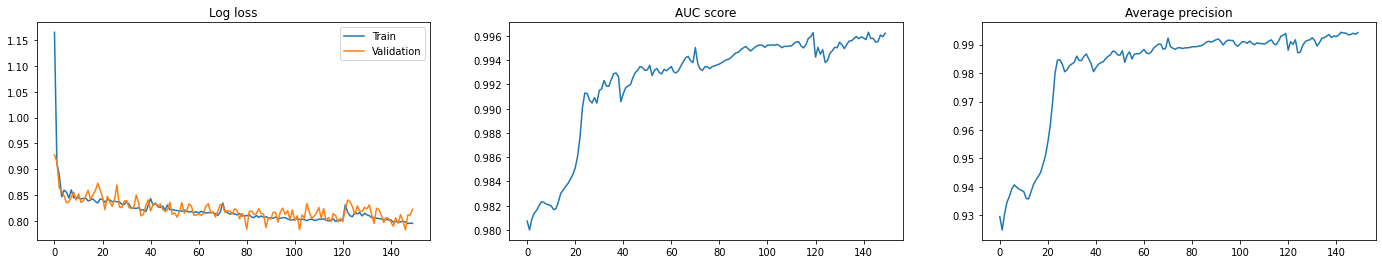

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

ax[0].set_title("Log loss")
ax[0].plot(training_losses, label="Train")
ax[0].plot(validation_losses, label="Validation")
ax[0].legend()

ax[1].set_title("AUC score")
ax[1].plot(val_auc)

ax[2].set_title("Average precision")
ax[2].plot(val_ap)

#### Inspect node embeddings

Now that our model is trained, we can visualize the node embeddings. We decided that our node embeddings are 64-dimensional (8 dimensions * 8 heads). We can easily convert this to a 2D visualization using any visualization algorithm. We will not go into any interpretation here, as the point of the notebook is to demonstrate how to actually fit these models.

In [62]:
node_types = {}
for i in range(len(data.edge_type)):
    n1, n2 = data.edge_index[:, i]
    et = data.edge_type[i]
    if et == EdgeType.DRUG_DRUG:
        node_types[int(n1)] = NodeType.DRUG
        node_types[int(n2)] = NodeType.DRUG
    elif et == EdgeType.DRUG_GENE:
        node_types[int(n1)] = NodeType.DRUG
        node_types[int(n2)] = NodeType.GENE
    elif et == EdgeType.GENE_DRUG:
        node_types[int(n1)] = NodeType.GENE
        node_types[int(n2)] = NodeType.DRUG
    
len(node_types)

7064

In [63]:
node_types = np.array([node_types[i] for i in range(len(node_types))])
node_types

array([1, 1, 1, ..., 1, 2, 1])

In [64]:
pd.Series.value_counts(node_types)

1    4937
2    2127
dtype: int64

In [65]:
embedding = z.cpu().detach().numpy()
embedding = embedding[node_types == NodeType.DRUG]
embedding

array([[0.0608276 , 0.        , 0.00107447, ..., 0.        , 0.0007066 ,
        0.04620501],
       [0.0422214 , 0.        , 0.00108223, ..., 0.        , 0.00070706,
        0.06555749],
       [0.04572241, 0.        , 0.0009964 , ..., 0.        , 0.00065476,
        0.06131272],
       ...,
       [0.00111852, 0.        , 0.0021924 , ..., 0.        , 0.00137599,
        0.        ],
       [0.00101082, 0.        , 0.00222677, ..., 0.        , 0.00145768,
        0.        ],
       [0.00106103, 0.        , 0.00200004, ..., 0.        , 0.00142089,
        0.        ]], dtype=float32)

In [66]:
embedding.shape

(4937, 64)

In [67]:
from openTSNE import TSNE

tsne_embedding = TSNE(exaggeration=1, n_jobs=4).fit(embedding)

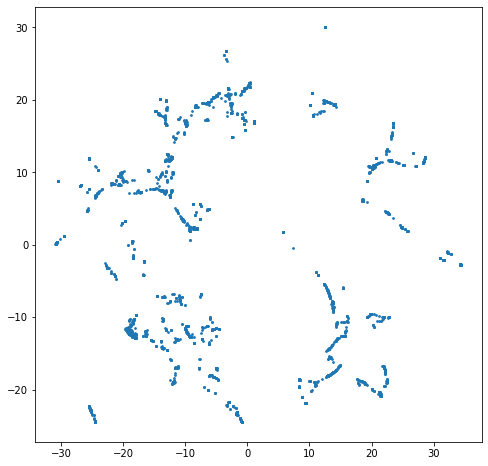

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c="tab:blue", s=3)